This notebook starts with a dataset containing close-up photos of different people's gazes, divided by each eye. The goal is to develop a model that is able to predict whether or not each person's gaze is directed towards the center.

# Phase 1: Dataset preparation

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

#data = np.load('/kaggle/input/gaze-direction-detection/dataset.npz')
data = np.load('dataset.npz')
print(data)

NpzFile 'dataset.npz' with keys: right_eyes, left_eyes, targets


In [2]:
right_eyes_data = data['right_eyes']
left_eyes_data = data['left_eyes']
target = data['targets'].reshape(-1, 1)

print(f"-> Right eyes shape: {right_eyes_data.shape}\n-> Left eyes shape: {left_eyes_data.shape}\n-> Targets: {target.shape}")

-> Right eyes shape: (53000, 64, 64, 3)
-> Left eyes shape: (53000, 64, 64, 3)
-> Targets: (53000, 1)


The dataset is divided into the right and left eyes, and also target, which have a binary information showing if each person is looking at the center or not.

## Understanting the dataset

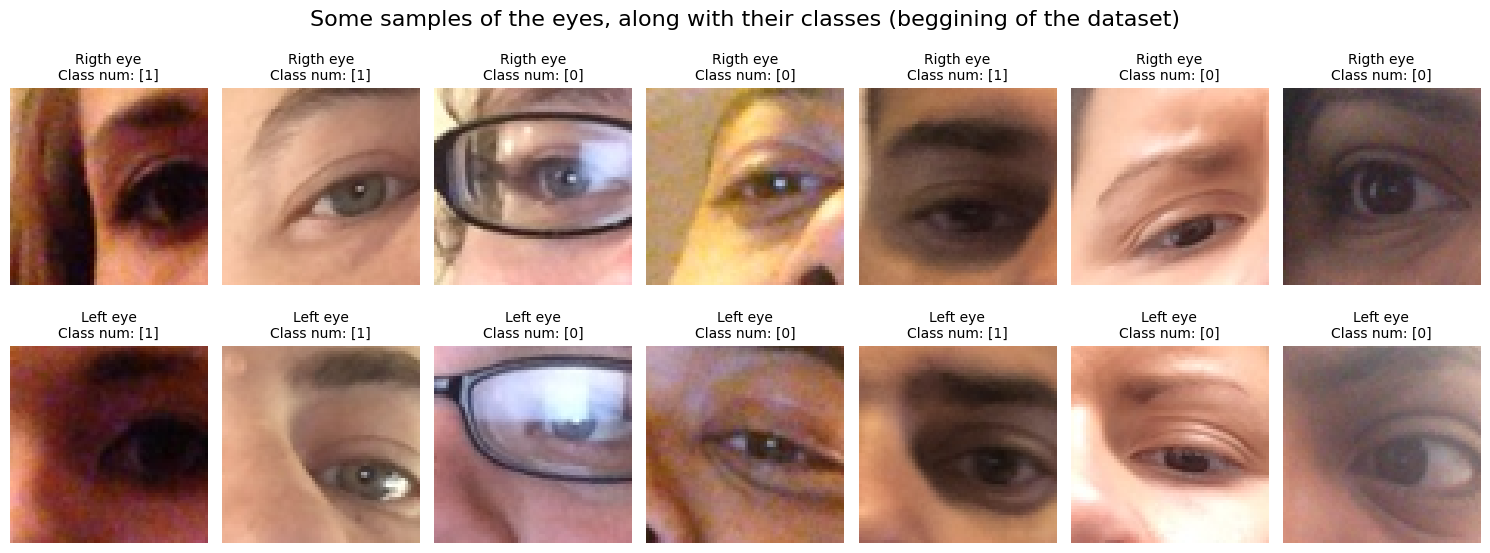

In [3]:
fig, axes = plt.subplots(2, 7, figsize=(15, 6))
fig.suptitle("Some samples of the eyes, along with their classes (beggining of the dataset)", fontsize=16)

for i in range(7):
    axes[0, i].imshow(right_eyes_data[i].astype(np.uint8))
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Rigth eye\nClass num: {target[i]}", fontsize=10)

    axes[1, i].imshow(left_eyes_data[i].astype(np.uint8))
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Left eye\nClass num: {target[i]}", fontsize=10)

plt.tight_layout()
plt.show()

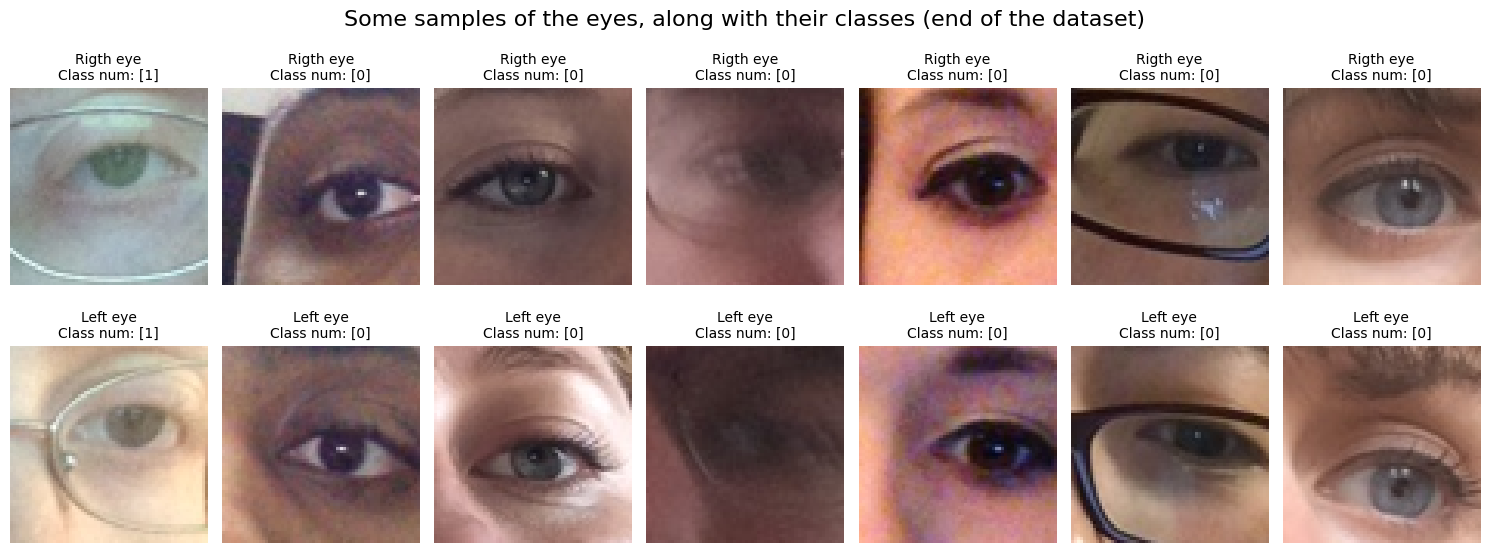

In [4]:
fig, axes = plt.subplots(2, 7, figsize=(15, 6))
fig.suptitle("Some samples of the eyes, along with their classes (end of the dataset)", fontsize=16)

for i in range(7):
    j = len(right_eyes_data) - i - 1
    
    axes[0, i].imshow(right_eyes_data[j].astype(np.uint8))
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Rigth eye\nClass num: {target[j]}", fontsize=10)

    axes[1, i].imshow(left_eyes_data[j].astype(np.uint8))
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Left eye\nClass num: {target[j]}", fontsize=10)

plt.tight_layout()
plt.show()

In [5]:
def plot_gaze_distribution(target):
    unique, counts_uniques = np.unique(target, return_counts=True)
    print(f"Number of class 0 samples (not look ahead): {counts_uniques[0]}")
    print(f"Number of class 1 samples (look ahead): {counts_uniques[1]}")

    plt.bar(unique, counts_uniques)
    plt.title("Gaze distribution")
    plt.xticks([0, 1])
    plt.xlabel("Look ahead (0 no - 1 yes)")
    plt.ylabel("Quantity")
    plt.show()

    return counts_uniques

Number of class 0 samples (not look ahead): 36111
Number of class 1 samples (look ahead): 16889


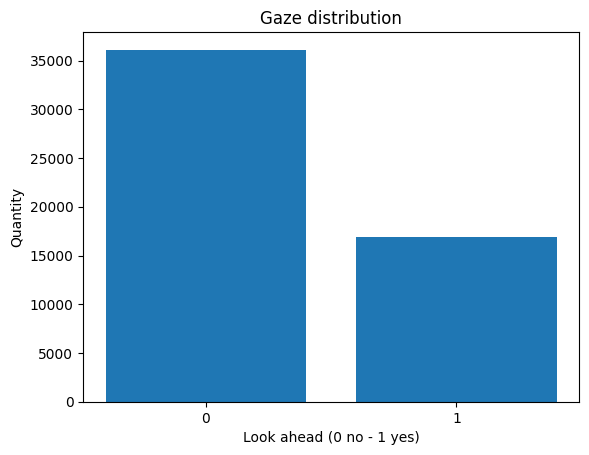

In [6]:
count_uniques = plot_gaze_distribution(target)

At this point, it's clear that class 0 indicates that the person is looking ahead and class 1 the opposite. Also, the classes are not balanced.

## Preprocessing

In [7]:
# Check total black images in the datases
right_eye_totalblack = np.where(np.all(right_eyes_data == 0, axis=(1, 2, 3)))[0]
left_eye_totalblack = np.where(np.all(left_eyes_data == 0, axis=(1, 2, 3)))[0]
print('Total number of black images in right eye is', len(right_eye_totalblack), 'and in the left eye is', len(left_eye_totalblack))

Total number of black images in right eye is 0 and in the left eye is 0


In [8]:
# Check duplicate images in the dataset using hash (efficiency)
import hashlib

def hash_calculator(imagen): return hashlib.md5(imagen.tobytes()).hexdigest()

right_hashes = [hash_calculator(img) for img in right_eyes_data]
unique_hashes_right = set(right_hashes)
num_duplicates_right = len(right_hashes) - len(unique_hashes_right)

left_hashes = [hash_calculator(img) for img in left_eyes_data]
unique_hashes_left = set(left_hashes)
num_duplicates_left = len(left_hashes) - len(unique_hashes_left)

print('Total number of duplicated images in right eye is', num_duplicates_right, 'and in the left eye is', num_duplicates_left)

Total number of duplicated images in right eye is 0 and in the left eye is 0


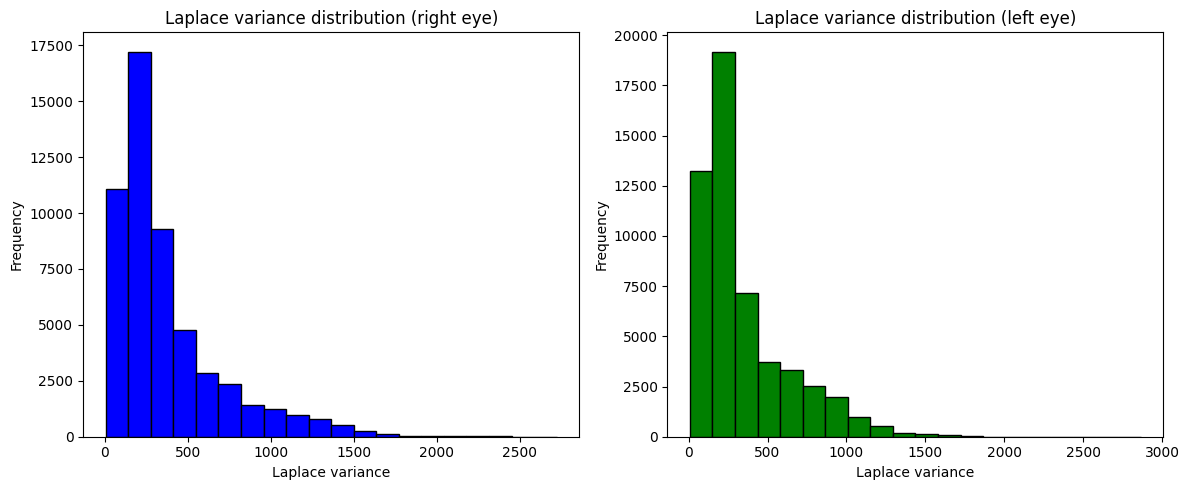

[Right eye] Min variance: 6.558066368103027, Mean variance: 373.7094978071215, Max variance: 2723.9639031887054
[Left eye] Min variance: 8.841306447982788, Mean variance: 342.82797061421735, Max variance: 2864.4810540676117


In [9]:
# Calculate laplace variance for detecting blurred images
def calculate_laplace_variance(image):
    gray_con = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplace = cv2.Laplacian(gray_con, cv2.CV_64F)
    var = laplace.var()
    return var

laplace_vars_right = [calculate_laplace_variance(right_eyes_data[i].astype(np.uint8)) for i in range(len(right_eyes_data))]
laplace_vars_left = [calculate_laplace_variance(left_eyes_data[i].astype(np.uint8)) for i in range(len(left_eyes_data))]

fig, axes = plt.subplots(1, 2, figsize=(12, 5)) 

axes[0].hist(laplace_vars_right, bins=20, color='blue', edgecolor='black')
axes[0].set_xlabel('Laplace variance')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Laplace variance distribution (right eye)')

axes[1].hist(laplace_vars_left, bins=20, color='green', edgecolor='black')
axes[1].set_xlabel('Laplace variance')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Laplace variance distribution (left eye)')

plt.tight_layout()
plt.show()


print(f"[Right eye] Min variance: {min(laplace_vars_right)}, Mean variance: {np.mean(laplace_vars_right)}, Max variance: {max(laplace_vars_right)}")
print(f"[Left eye] Min variance: {min(laplace_vars_left)}, Mean variance: {np.mean(laplace_vars_left)}, Max variance: {max(laplace_vars_left)}")

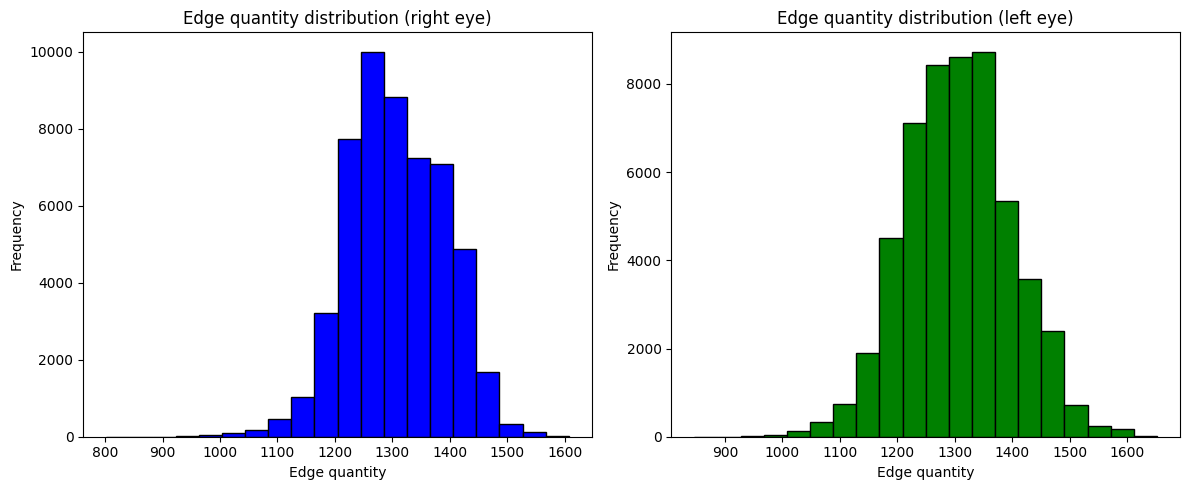

[Right eye] Min num edges: 802, Mean num edges: 1306.178396226415, Max num edges: 1607
[Left eye] Min num edges: 847, Mean num edges: 1306.320245283019, Max num edges: 1652


In [ ]:
def get_num_edges(image):
    gray_con = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_con, 1, 2) 
    num_edges = np.sum(edges > 0)
    return num_edges

num_edges_right = [get_num_edges(right_eyes_data[i].astype(np.uint8)) for i in range(len(right_eyes_data))] 
num_edges_left = [get_num_edges(left_eyes_data[i].astype(np.uint8)) for i in range(len(left_eyes_data))]  

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(num_edges_right, bins=20, color='blue', edgecolor='black')
axes[0].set_xlabel('Edge quantity')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Edge quantity distribution (right eye)')

axes[1].hist(num_edges_left, bins=20, color='green', edgecolor='black')
axes[1].set_xlabel('Edge quantity')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Edge quantity distribution (left eye)')

plt.tight_layout()
plt.show()

print(f"[Right eye] Min num edges: {min(num_edges_right)}, Mean num edges: {np.mean(num_edges_right)}, Max num edges: {max(num_edges_right)}")
print(f"[Left eye] Min num edges: {min(num_edges_left)}, Mean num edges: {np.mean(num_edges_left)}, Max num edges: {max(num_edges_left)}")

It has already been verified that we do not have duplicate images or black images. Then, the Laplace distribution has been checked to detect blurred images and the contours of the images have been calculated looking for blurred images.

With this graphed, we have some average values ​​on which we can perform image cleaning, which will be done later.

In [11]:
# Normalize samples (RGB channels)
right_eyes_data = right_eyes_data.astype(np.float32) / 255.0
left_eyes_data = left_eyes_data.astype(np.float32) / 255.0

In [12]:
# Concatenate eyes in the channels axis
combined_eyes_pictures = np.concatenate([right_eyes_data, left_eyes_data], axis=-1)
print("Shape after combine eyes:", combined_eyes_pictures.shape)

Shape after combine eyes: (53000, 64, 64, 6)


In [13]:
# Concatenate eyes but maintaining only 3 channels
combined_eyes_pictures_3ch = (right_eyes_data + left_eyes_data) / 2.0 
print("Shape after combine eyes:", combined_eyes_pictures_3ch.shape)

Shape after combine eyes: (53000, 64, 64, 3)


In [14]:
from sklearn.model_selection import train_test_split

def preprocessing_images_split_train_test_val(train_size, test_size, data, target, prints=False):
    """
    Balance the dataset so that each class has exactly 'num_per_class' samples.
    
    Parameters:
    - train_size: float indicating train size.
    - test_size: float indicating train size.
    - data: numpy array with data to split.
    - targets: numpy array with labels (0 or 1).
    - prints: boolean that shows or not information in console.
    
    Returns:
    - x_train: numpy array with train data.
    - y_train: numpy array with targets train data.
    - x_test: numpy array with test data.
    - y_test: numpy array with targets test data.
    - x_val: numpy array with validation data.
    - y_val: numpy array with targets validation data.
    """

    if train_size >= 1 or test_size >= 1 or train_size+test_size > 1:
        print("Params of train_size and test_size must be less than 1, and the sum of them too")
        return None, None, None, None, None, None
    
    #if train_size+test_size == 1:
    #    print("Sum of train_size and test_size is 1, skipping val splitting")

    val_size = round(1-train_size-test_size, 2)
    initial_test_size = round(1-train_size, 2)
    final_test_size = round(test_size/(test_size+val_size), 2)
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        data, target, test_size=initial_test_size, random_state=42, stratify=target
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=final_test_size, random_state=42, stratify=y_temp
    )

    if prints:
        print("-> Train set, X shape is ", X_train.shape, "and Y shape is", y_train.shape)
        print("-> Test set, X shape is ", X_val.shape, "and Y shape is", y_val.shape)
        print("-> Validation set, X shape is ", X_test.shape, "and Y shape is", y_test.shape)

    return X_train, y_train, X_test, y_test, X_val, y_val

In [15]:
X_train, y_train, X_test, y_test, X_val, y_val = preprocessing_images_split_train_test_val(
    train_size=0.7, test_size=0.15, data=combined_eyes_pictures, target=target, prints=True
)

-> Train set, X shape is  (37100, 64, 64, 6) and Y shape is (37100, 1)
-> Test set, X shape is  (7950, 64, 64, 6) and Y shape is (7950, 1)
-> Validation set, X shape is  (7950, 64, 64, 6) and Y shape is (7950, 1)


Number of class 0 samples (not look ahead): 25278
Number of class 1 samples (look ahead): 11822


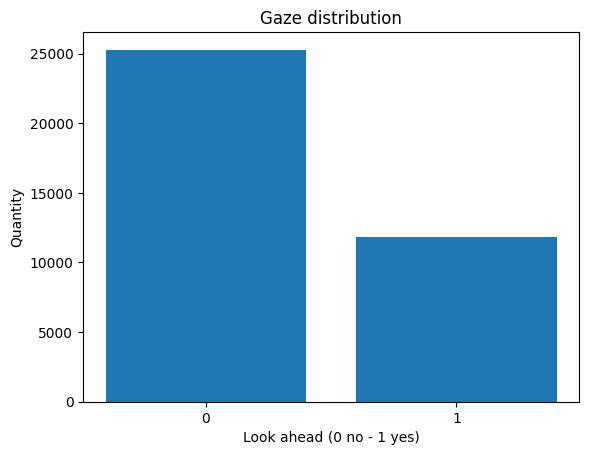

Number of class 0 samples (not look ahead): 5416
Number of class 1 samples (look ahead): 2534


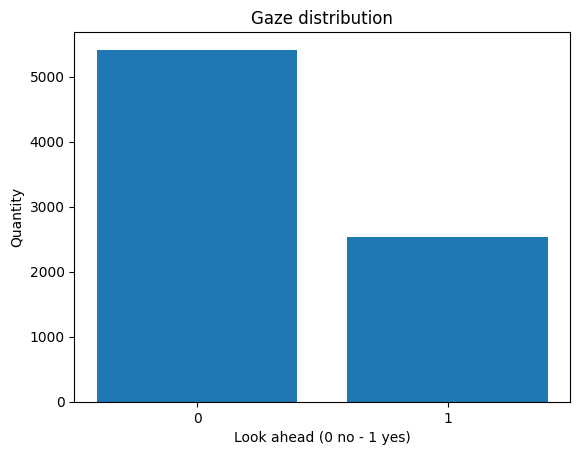

Number of class 0 samples (not look ahead): 5417
Number of class 1 samples (look ahead): 2533


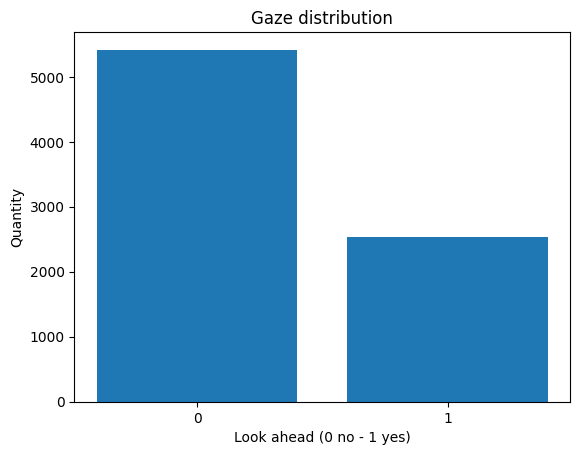

In [16]:
for each_target in [y_train, y_val, y_test]: _ = plot_gaze_distribution(each_target)

In [17]:
X_train_3ch, y_train_3ch, X_test_3ch, y_test_3ch, X_val_3ch, y_val_3ch = preprocessing_images_split_train_test_val(
    train_size=0.7, test_size=0.15, data=combined_eyes_pictures_3ch, target=target, prints=True
)

-> Train set, X shape is  (37100, 64, 64, 3) and Y shape is (37100, 1)
-> Test set, X shape is  (7950, 64, 64, 3) and Y shape is (7950, 1)
-> Validation set, X shape is  (7950, 64, 64, 3) and Y shape is (7950, 1)


Number of class 0 samples (not look ahead): 25278
Number of class 1 samples (look ahead): 11822


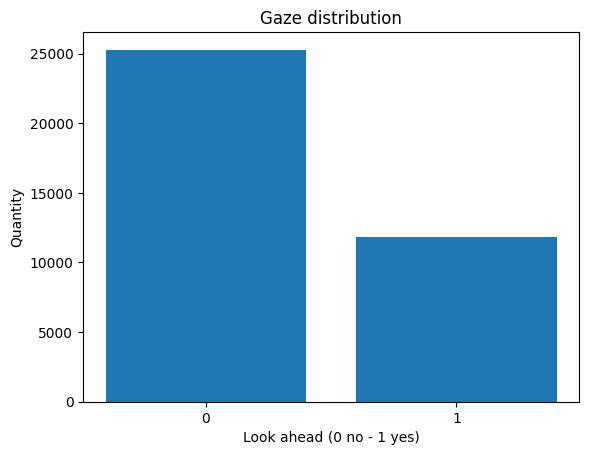

Number of class 0 samples (not look ahead): 5416
Number of class 1 samples (look ahead): 2534


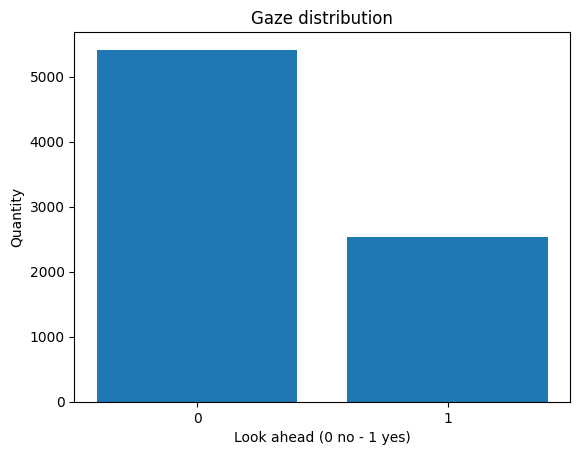

Number of class 0 samples (not look ahead): 5417
Number of class 1 samples (look ahead): 2533


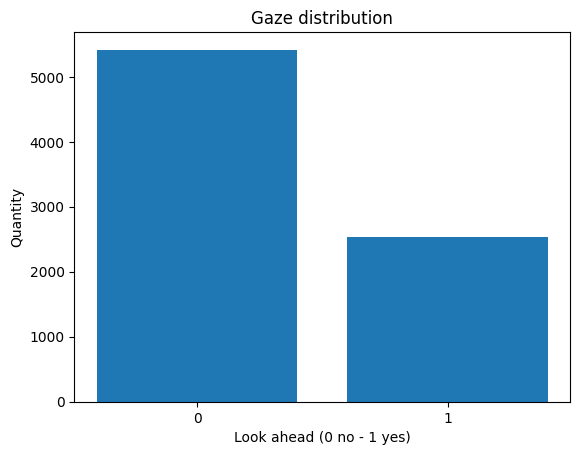

In [18]:
for each_target in [y_train_3ch, y_val_3ch, y_test_3ch]: _ = plot_gaze_distribution(each_target)

Finally, functions have been created to show the distribution of each class and to separate them into train, val and test datasets. The data have been processed both by merging them in the RGB dimension and by taking the average of the two corresponding mixed eyes, since tests will be carried out in both ways. 

# Phase 2: Model creation

For this first model creation, MobileNetv2 will be used with pre-trained 'imagenet' weights, relying on Transfer Learning. 

Layers have been added to reduce dimensionality and avoid overfitting, along with the binary output. Regarding training, a periodic adjustment of the learning rate has been added, along with saving the best model and stopping early if we do not obtain improvement in 10 epochs.

In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [20]:
base_model_mobilenet = MobileNetV2(include_top=False, input_shape=(64, 64, 3), weights='imagenet')

x = base_model_mobilenet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model_mobilenet = models.Model(inputs=base_model_mobilenet.input, outputs=output)
model_mobilenet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()

callbacks = [
    ModelCheckpoint(
        'model_mobilenet_50ep_32bat_best.keras', 
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

C:\Users\josep\AppData\Local\Temp\ipykernel_22336\2697720220.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(include_top=False, input_shape=(64, 64, 3), weights='imagenet')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 2,305,921 (8.80 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [21]:
history = model_mobilenet.fit(
    X_train_3ch, y_train_3ch,
    validation_data=(X_val_3ch, y_val_3ch),
    epochs=50,
    batch_size=32,
    callbacks=[callbacks]
)

Epoch 1/50
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6378 - loss: 0.6840
Epoch 1: val_loss improved from inf to 0.61209, saving model to model_mobilenet_50ep_32bat_best.keras
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 185s 133ms/step - accuracy: 0.6378 - loss: 0.6840 - val_accuracy: 0.6811 - val_loss: 0.6121 - learning_rate: 1.0000e-04
Epoch 2/50
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6946 - loss: 0.5821
Epoch 2: val_loss improved from 0.61209 to 0.58522, saving model to model_mobilenet_50ep_32bat_best.keras
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 153s 132ms/step - accuracy: 0.6946 - loss: 0.5821 - val_accuracy: 0.6936 - val_loss: 0.5852 - learning_rate: 1.0000e-04
Epoch 3/50
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7246 - loss: 0.5375
Epoch 3: val_loss improved from 0.58522 to 0.56680, saving model to model_mobilenet_50ep_32bat_best.keras
1160/1160 ━━━━━━━━━━━━━━━━━━━━ 159s 137ms/step - accuracy: 0.7246 - loss: 0.5374 - val_accuracy: 0.7258 - val_loss

# Phase 3: Model evaluation

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [23]:
def evaluate_process(model, X_test, y_test, history):

    y_pred_probs = model.predict(X_test, verbose=1)  
    y_pred = y_pred_probs > 0.5
    y_true = y_test           

    conf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No look forward', 'Look forward'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['No look forward', 'Look forward']))

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')
    plt.show()

249/249 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step


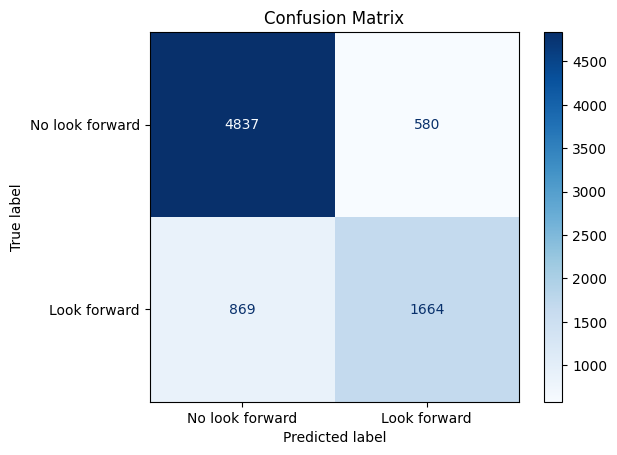

Classification Report:
                 precision    recall  f1-score   support

No look forward       0.85      0.89      0.87      5417
   Look forward       0.74      0.66      0.70      2533

       accuracy                           0.82      7950
      macro avg       0.79      0.77      0.78      7950
   weighted avg       0.81      0.82      0.81      7950

249/249 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8161 - loss: 0.4506
Test Loss: 0.4524
Test Accuracy: 0.8177


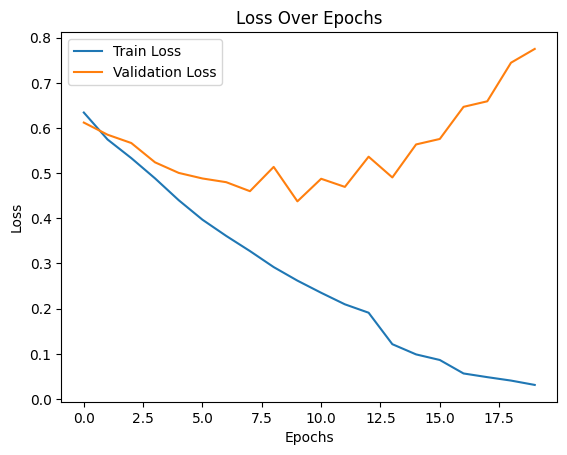

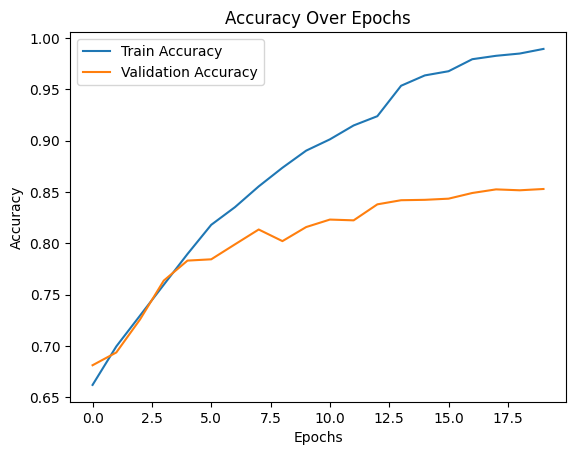

In [24]:
evaluate_process(model_mobilenet, X_test_3ch, y_test_3ch, history)

A function has been created to calculate and graph metrics related to the training.

Looking at the metrics obtained from this training, we can see that the model has an accuracy close to 80%, where it has better precision with people who do not look straight ahead (probably because we have more images of this kind).

# Phase 4: Optimization

## Data augmentation & undersampling

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

def preprocessing_images_dataaug_undersampling(right_eye_data, left_eye_data, targets, num_per_class, channels_3=False, separate_eyes=False):
    """
    Balance the dataset so that each class has exactly 'num_per_class' samples.
    
    Parameters:
    - right_eye_data: numpy array with right eye images
    - left_eye_data: numpy array with left right eye images
    - targets: numpy array with labels (0 or 1).
    - num_per_class: desired number of images per class.
    - channels_3: option to return the balanced_images with 3 RGB channels
    - separate_eyes: option to return the balanced_images separated into two arrays (one per eye)
    
    Returns:
    - balanced_images: numpy array with balanced and combined images.
    - targets_balanced: numpy array with balanced labels.
    """

    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    class0_indexes = np.where(targets == 0)[0]
    class1_indexes = np.where(targets == 1)[0]
    
    new_right_eye_images = []
    new_left_eye_images = []
    new_targets = []
    
    for class_index, class_type in [(class0_indexes, 0), (class1_indexes, 1)]:
        right_images_classtype = right_eye_data[class_index]
        left_images_classtype = left_eye_data[class_index]
        
        if len(right_images_classtype) > num_per_class:
            # Undersampling
            indexes_undersampling = np.random.choice(len(right_images_classtype), num_per_class, replace=False)
            new_right_eye_images.extend(right_images_classtype[indexes_undersampling])
            new_left_eye_images.extend(left_images_classtype[indexes_undersampling])
            new_targets.extend([class_type] * num_per_class)
        else:
            # Data augmentation
            new_right_eye_images.extend(right_images_classtype)
            new_left_eye_images.extend(left_images_classtype)
            new_targets.extend([class_type] * len(right_images_classtype))
            
            increase_number = num_per_class - len(right_images_classtype)
            for _ in range(increase_number):
                idx = np.random.randint(0, len(right_images_classtype))
                
                imagen_aumentada_derecho = datagen.random_transform(right_images_classtype[idx])
                new_right_eye_images.append(imagen_aumentada_derecho)
                
                imagen_aumentada_izquierdo = datagen.random_transform(left_images_classtype[idx])
                new_left_eye_images.append(imagen_aumentada_izquierdo)
                
                new_targets.append(class_type)
    
    new_right_eye_images = np.array(new_right_eye_images)
    new_left_eye_images = np.array(new_left_eye_images)
    balanced_targets = np.array(new_targets)

    if separate_eyes: return new_right_eye_images, new_left_eye_images, balanced_targets
    if channels_3: balanced_combined_images = (new_right_eye_images+new_left_eye_images) / 2.0
    else: balanced_combined_images = np.concatenate([new_right_eye_images, new_left_eye_images], axis=-1)
    
    return balanced_combined_images, balanced_targets


Classes distribution after data treatment: Counter({0: 36111, 1: 36111})
Number of class 0 samples (not look ahead): 36111
Number of class 1 samples (look ahead): 36111


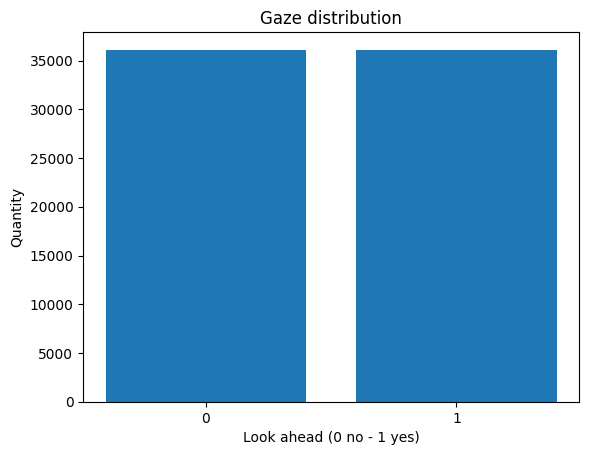

-> Train set, X shape is  (50555, 64, 64, 6) and Y shape is (50555,)
-> Test set, X shape is  (10833, 64, 64, 6) and Y shape is (10833,)
-> Validation set, X shape is  (10834, 64, 64, 6) and Y shape is (10834,)


In [26]:
# Data augmentation maintaining 6 channels

balanced_combined_images, balanced_targets = preprocessing_images_dataaug_undersampling(right_eyes_data, left_eyes_data, target, count_uniques[0])
class1_dataaug = (balanced_combined_images, balanced_targets)

print("Classes distribution after data treatment:", Counter(class1_dataaug[1]))
_ = plot_gaze_distribution(class1_dataaug[1])

X_train_da, y_train_da, X_test_da, y_test_da, X_val_da, y_val_da = preprocessing_images_split_train_test_val(
    train_size=0.7, test_size=0.15, data=class1_dataaug[0], target=class1_dataaug[1], prints=True
)

For optimization purposes, a function has been created that allows us to perform data augmentation and undersampling at the same time, adjusting the data of each class so that they are balanced. Using this function, we leave behind the problems of poor balance and we can .

## Models creation
### Simple CNN

In [28]:
model_simple_cnn = models.Sequential([   
    layers.Input(shape=(64, 64, 6)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model_simple_cnn.compile(optimizer=Adam(learning_rate=0.0001), 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

model_simple_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,649 (436.13 KB)

 Trainable params: 111,201 (434.38 KB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
callbacks = [
    ModelCheckpoint(
        'model_cnn_simple_50ep_32bat_best.keras', 
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
]


In [30]:
history2 = model_simple_cnn.fit(
    X_train_da, y_train_da,
    validation_data=(X_val_da, y_val_da),
    epochs=50,
    batch_size=32,
    callbacks=[callbacks]
)

Epoch 1/50
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7389 - loss: 0.4895
Epoch 1: val_loss improved from inf to 0.44088, saving model to model_cnn_simple_50ep_32bat_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 94s 58ms/step - accuracy: 0.7389 - loss: 0.4895 - val_accuracy: 0.7690 - val_loss: 0.4409 - learning_rate: 1.0000e-04
Epoch 2/50
1579/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7658 - loss: 0.4453
Epoch 2: val_loss improved from 0.44088 to 0.43649, saving model to model_cnn_simple_50ep_32bat_best.keras
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 90s 57ms/step - accuracy: 0.7658 - loss: 0.4453 - val_accuracy: 0.7693 - val_loss: 0.4365 - learning_rate: 1.0000e-04
Epoch 3/50
1579/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7658 - loss: 0.4443
Epoch 3: val_loss did not improve from 0.43649
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 87s 55ms/step - accuracy: 0.7658 - loss: 0.4443 - val_accuracy: 0.7694 - val_loss: 0.4386 - learning_rate: 1.0000e-04
Epoch 4/50
1579/1580 ━━━━━━━━

339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


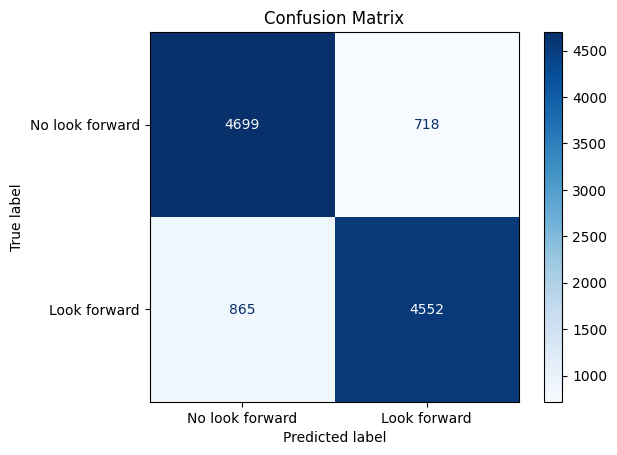

Classification Report:
                 precision    recall  f1-score   support

No look forward       0.84      0.87      0.86      5417
   Look forward       0.86      0.84      0.85      5417

       accuracy                           0.85     10834
      macro avg       0.85      0.85      0.85     10834
   weighted avg       0.85      0.85      0.85     10834

339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8552 - loss: 0.3238
Test Loss: 0.3238
Test Accuracy: 0.8539


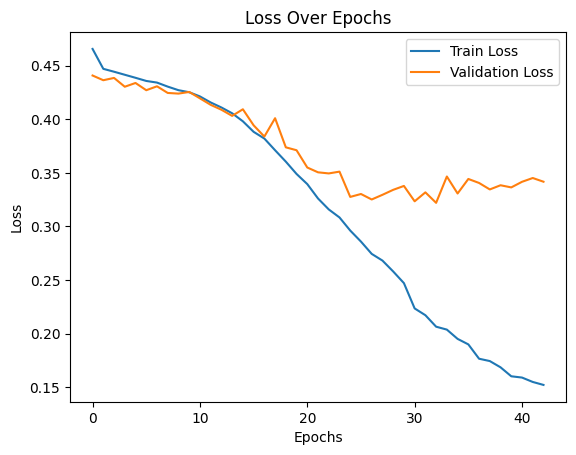

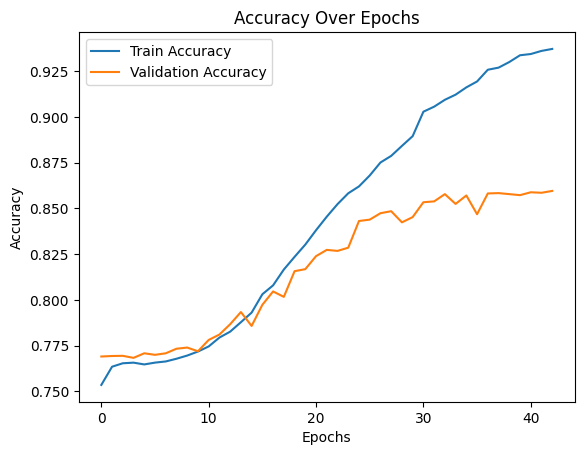

In [31]:
evaluate_process(model_simple_cnn, X_test_da, y_test_da, history2)

This second model is going to be created from scratch and creating a simple CNN network. In the creation of this model, the two combined images are going to be used in the RGB channel, where layers are going to be used again to reduce dimensionality and eliminate linearity, along with other layers that help with regularization.

Regarding the metrics obtained from training, it can be seen that the model has an accuracy of 85%, obtaining a significant improvement over the previous model and adjusting the performance between the two classes more. In the graph we can see that from epoch 25/30 onwards the validation accuracy barely increases.

### Simple CNN v2

In [59]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import recall_score

In [60]:
class RecallCallback(Callback):
    def __init__(self, val_data):
        super(RecallCallback, self).__init__()
        self.val_data = val_data  

    def on_epoch_end(self, epoch, logs=None):
        val_X, val_y = self.val_data 
        y_pred = self.model.predict(val_X)
        
        y_pred_classes = (y_pred > 0.5).astype("int32")
        
        recall0 = recall_score(val_y, y_pred_classes, pos_label=0)
        recall1 = recall_score(val_y, y_pred_classes, pos_label=1)
        
        print(f"Validation Recall of class 0: {recall0:.4f}")
        print(f"Validation Recall of class 1: {recall1:.4f}")
        
        return

In [61]:
recall_callback = RecallCallback(val_data=(X_val_da, y_val_da))

model_simple_cnn_2 = models.Sequential([   
    layers.Input(shape=(64, 64, 6)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(), #layers.Flatten()
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3, 
    decay_steps=3000,  
    decay_rate=0.95,  
    staircase=False  
)

model_simple_cnn_2.compile(optimizer=Adam(learning_rate=lr_schedule), 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

model_simple_cnn_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,649 (436.13 KB)

 Trainable params: 111,201 (434.38 KB)

 Non-trainable params: 448 (1.75 KB)

In [62]:
callbacks = [
    ModelCheckpoint(
        'model_cnn_simple_50ep_32bat_v2_best.keras', 
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    #ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history3 = model_simple_cnn_2.fit(
    X_train_da, y_train_da,
    validation_data=(X_val_da, y_val_da),
    epochs=50,
    batch_size=32,
    callbacks=[callbacks, recall_callback]
)

Epoch 1/50
1579/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7543 - loss: 0.4773
Epoch 1: val_loss improved from inf to 0.44786, saving model to model_cnn_simple_50ep_32bat_v2_best.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Validation Recall of class 0: 1.0000
Validation Recall of class 1: 0.5386
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 100s 62ms/step - accuracy: 0.7543 - loss: 0.4773 - val_accuracy: 0.7693 - val_loss: 0.4479
Epoch 2/50
1579/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7611 - loss: 0.4602
Epoch 2: val_loss did not improve from 0.44786
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Validation Recall of class 0: 1.0000
Validation Recall of class 1: 0.5386
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - accuracy: 0.7611 - loss: 0.4602 - val_accuracy: 0.7693 - val_loss: 0.4494
Epoch 3/50
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7651 - loss: 0.4536
Epoch 3: val_loss did not improve from 0.44786
339/339 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Validation Recall 

339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


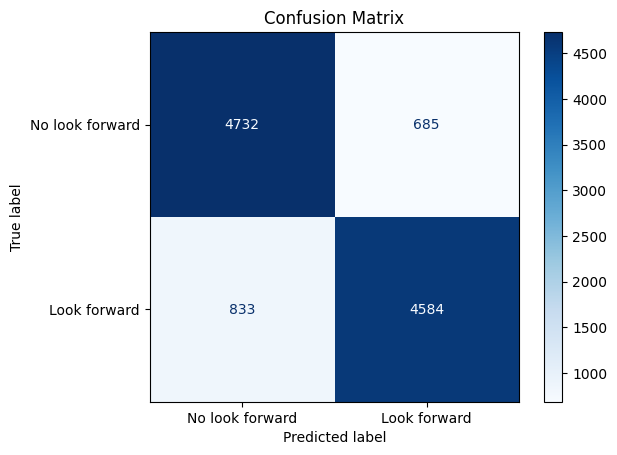

Classification Report:
                 precision    recall  f1-score   support

No look forward       0.85      0.87      0.86      5417
   Look forward       0.87      0.85      0.86      5417

       accuracy                           0.86     10834
      macro avg       0.86      0.86      0.86     10834
   weighted avg       0.86      0.86      0.86     10834

339/339 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8590 - loss: 0.3154
Test Loss: 0.3142
Test Accuracy: 0.8599


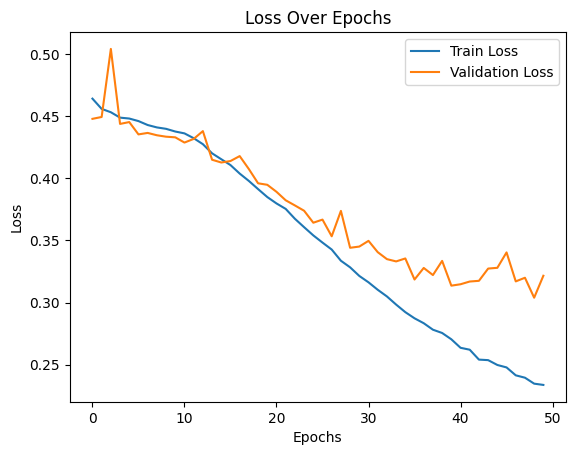

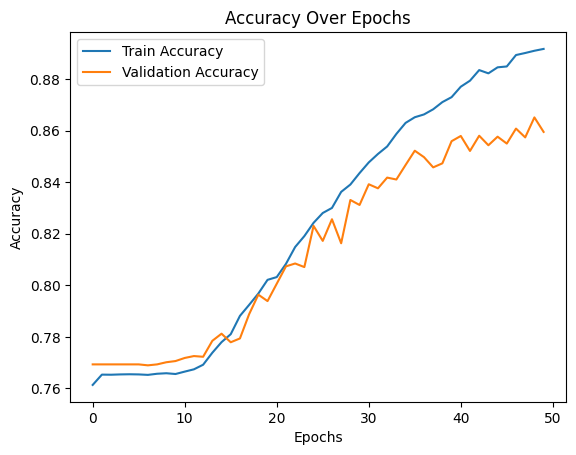

In [63]:
evaluate_process(model_simple_cnn_2, X_test_da, y_test_da, history3)

Starting from the previous model, certain changes have been applied:

- Redefined the behavior at the end of each epoch to show the recall of the classes
- Updated the way in which the learning rate is updated, using ExponentialDecay for more precise control.

Regarding the metrics obtained from training, the model again obtains better results, around 86%. Again, a significant improvement is obtained compared to the previous model, although an imbalance of precision between the classes is observed. Looking at the graph, it can be seen how the validation precision increases in line with the training precision, leading to better results.

### MobileNet with 2 inputs

In [64]:
# Redefinition of the split function to receive and return datasets of each eye separately
def preprocessing_images_split_train_test_val_separate_eyes(train_size, test_size, data_right, data_left, target, prints=False):
    """
    Split the dataset into train, test, and validation sets for both right and left eye data,
    keeping the correspondence between the data (same person).

    Parameters:
    - train_size: float indicating train size.
    - test_size: float indicating test size.
    - data_right: numpy array with data for the right eyes.
    - data_left: numpy array with data for the left eyes.
    - target: numpy array with labels (0 or 1).
    - prints: boolean to display information in the console.
    
    Returns:
    - x_train_right: numpy array with train data for right eyes.
    - x_train_left: numpy array with train data for left eyes.
    - y_train: numpy array with train targets.
    - x_test_right: numpy array with test data for right eyes.
    - x_test_left: numpy array with test data for left eyes.
    - y_test: numpy array with test targets.
    - x_val_right: numpy array with validation data for rigth eyes.
    - x_val_left: numpy array with validation data for left eyes.
    - y_val: numpy array with validation targets.
    """
    
    if train_size >= 1 or test_size >= 1 or train_size + test_size > 1:
        print("Params of train_size and test_size must be less than 1, and the sum of them too")
        return None, None, None, None, None, None, None, None, None
    
    val_size = round(1-train_size-test_size, 2)
    initial_test_size = round(1-train_size, 2)
    final_test_size = round(test_size/(test_size+val_size), 2)
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        list(zip(data_right, data_left)), target, test_size=initial_test_size, random_state=42, stratify=target
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=final_test_size, random_state=42, stratify=y_temp
    )

    X_train_right, X_train_left = zip(*X_train)
    X_val_right, X_val_left = zip(*X_val)
    X_test_right, X_test_left = zip(*X_test)
    
    X_train_right, X_train_left = np.array(X_train_right), np.array(X_train_left)
    X_val_right, X_val_left = np.array(X_val_right), np.array(X_val_left)
    X_test_right, X_test_left = np.array(X_test_right), np.array(X_test_left)
    
    if prints:
        print("-> Train set, Right eye shape is", X_train_right.shape, "- left eye shape is", X_train_left.shape, "- target shape is", y_train.shape)
        print("-> Test set, Right eye shape is", X_val_right.shape, "- left eye shape is", X_val_left.shape, "- target shape is", y_val.shape)
        print("-> Validation set, Right eye shape is", X_test_right.shape, "- left eye shape is", X_test_left.shape, "- target shape is", y_test.shape)
    
    return X_train_right, X_train_left, y_train, X_test_right, X_test_left, y_test, X_val_right, X_val_left, y_val


Classes distribution after data treatment: Counter({0: 36111, 1: 36111})
Number of class 0 samples (not look ahead): 36111
Number of class 1 samples (look ahead): 36111


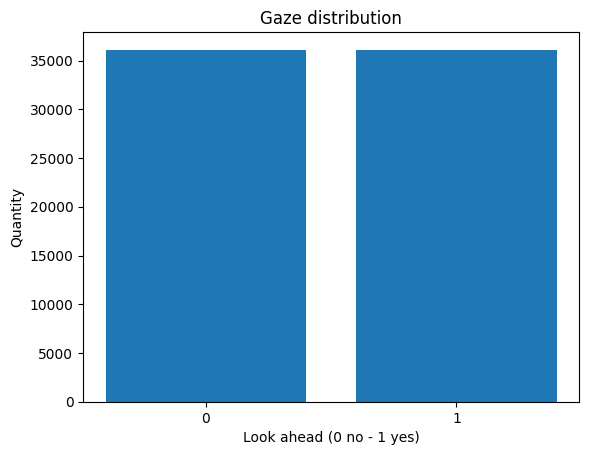

-> Train set, Right eye shape is (50555, 64, 64, 3) - left eye shape is (50555, 64, 64, 3) - target shape is (50555,)
-> Test set, Right eye shape is (10833, 64, 64, 3) - left eye shape is (10833, 64, 64, 3) - target shape is (10833,)
-> Validation set, Right eye shape is (10834, 64, 64, 3) - left eye shape is (10834, 64, 64, 3) - target shape is (10834,)


In [65]:
# Data augmentation maintaining two eyes separate

balanced_combined_right_eye_images, balanced_combined_left_eye_images, balanced_targets = preprocessing_images_dataaug_undersampling(right_eyes_data, left_eyes_data, target, count_uniques[0], separate_eyes=True)
class1_dataaug_separateeyes = (balanced_combined_right_eye_images, balanced_combined_left_eye_images, balanced_targets)

print("Classes distribution after data treatment:", Counter(class1_dataaug_separateeyes[2]))
_ = plot_gaze_distribution(class1_dataaug_separateeyes[2])

X_train_right, X_train_left, y_train, X_test_right, X_test_left, y_test, X_val_right, X_val_left, y_val = preprocessing_images_split_train_test_val_separate_eyes(
    train_size=0.7, test_size=0.15, data_right=class1_dataaug_separateeyes[0], data_left=class1_dataaug_separateeyes[1], target=class1_dataaug_separateeyes[2], prints=True
)

In [66]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.models import Model


right_eye_input = Input(shape=(64, 64, 3), name="right_eye")
left_eye_input = Input(shape=(64, 64, 3), name="left_eye")

base_model_mobilenet_separatedeyes = MobileNetV2(include_top=False, input_shape=(64, 64, 3), weights='imagenet')

x_right = base_model_mobilenet_separatedeyes(right_eye_input)
x_left = base_model_mobilenet_separatedeyes(left_eye_input)

x_right = GlobalAveragePooling2D()(x_right)
x_left = GlobalAveragePooling2D()(x_left)

x_combined = layers.concatenate([x_right, x_left])

x = Dense(128, activation='relu')(x_combined)
x = layers.Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_mobilenet_separatedeyes = Model(inputs=[right_eye_input, left_eye_input], outputs=output)
model_mobilenet_separatedeyes.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model_mobilenet_separatedeyes.summary()

C:\Users\josep\AppData\Local\Temp\ipykernel_22336\3915110318.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet_separatedeyes = MobileNetV2(include_top=False, input_shape=(64, 64, 3), weights='imagenet')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ right_eye           │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left_eye            │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 2, 2,      │  2,257,984 │ right_eye[0][0],  │
│ (Functional)        │ 1280)             │            │ left_eye[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │    327,808 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,585,921 (9.86 MB)

 Trainable params: 2,551,809 (9.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [67]:
callbacks = [
    ModelCheckpoint(
        'model_mobilenet_separatedeyes_50ep_32bat_best.keras', 
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

recall_callback = RecallCallback(val_data=([X_val_right, X_val_left], y_val))

history4 = model_mobilenet_separatedeyes.fit(
    [X_train_right, X_train_left],  
    y_train,  
    validation_data=([X_val_right, X_val_left], y_val), 
    epochs=50, 
    batch_size=32,
    callbacks=[callbacks, recall_callback]  
)


Epoch 1/50
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.7275 - loss: 0.5203
Epoch 1: val_loss improved from inf to 0.41078, saving model to model_mobilenet_separatedeyes_50ep_32bat_best.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step
Validation Recall of class 0: 0.9701
Validation Recall of class 1: 0.6028
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 457s 266ms/step - accuracy: 0.7276 - loss: 0.5202 - val_accuracy: 0.7865 - val_loss: 0.4108 - learning_rate: 1.0000e-04
Epoch 2/50
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7848 - loss: 0.4070
Epoch 2: val_loss improved from 0.41078 to 0.36398, saving model to model_mobilenet_separatedeyes_50ep_32bat_best.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step
Validation Recall of class 0: 0.9550
Validation Recall of class 1: 0.6874
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 412s 261ms/step - accuracy: 0.7848 - loss: 0.4070 - val_accuracy: 0.8212 - val_loss: 0.3640 - learning_rate: 1.0000e-04
Epoch 3/50
1580/1580 ━━━━━━━━━━━━━━━━━━━━ 0s 241

339/339 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step


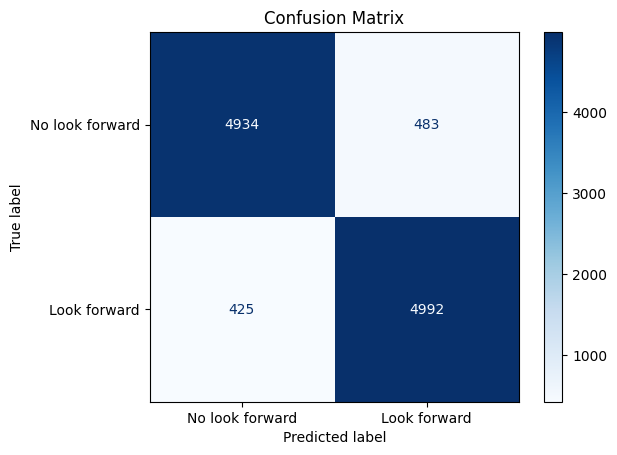

Classification Report:
                 precision    recall  f1-score   support

No look forward       0.92      0.91      0.92      5417
   Look forward       0.91      0.92      0.92      5417

       accuracy                           0.92     10834
      macro avg       0.92      0.92      0.92     10834
   weighted avg       0.92      0.92      0.92     10834

339/339 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.9192 - loss: 0.2284
Test Loss: 0.2298
Test Accuracy: 0.9162


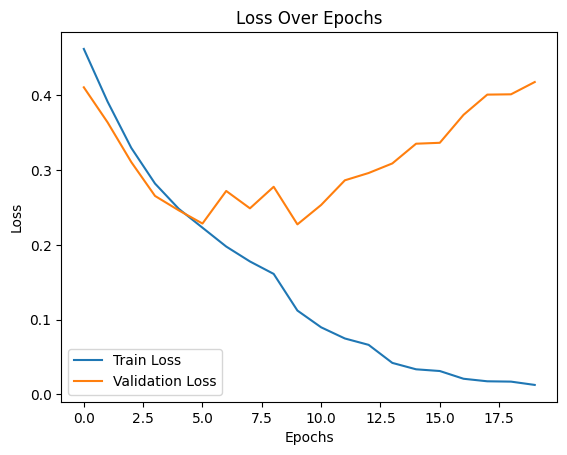

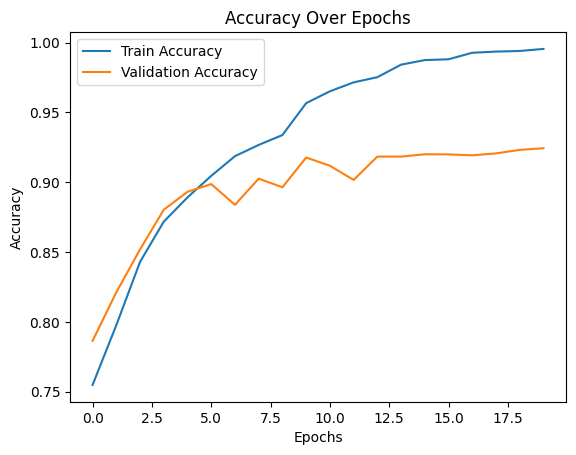

In [68]:
evaluate_process(model_mobilenet_separatedeyes, [X_test_right, X_test_left], y_test, history4)

For this test, we started from the first model that was created, but now the input of the model will be the eyes separately and they will be joined during the training pipeline.

Before the creation of the model, the function that separated the dataset into training, test and validation subdatasets was redefined, and now we obtain them separately by eye, ensuring that the indices are preserved so as not to lose the relationship between the eyes.

Regarding the metrics obtained from training, the results obtained are really good, reaching an accuracy of 92% and being by far the best model. In this case, there is also an improvement in class balancing, obtaining very close accuracy values ​​between them. Looking at the plot, it is worth noting that the validation accuracy stabilizes from approximately epoch 13.

## Data cleaning (blurred and moved images)

In [69]:
#Quick preprocessing, deleting blurred or moved images previously detected
indexes_to_delete = set()

for index in range(len(laplace_vars_right)):
    if laplace_vars_right[index] < 120: indexes_to_delete.add(index)

for index in range(len(laplace_vars_left)):
    if laplace_vars_left[index] < 100: indexes_to_delete.add(index)

for index in range(len(num_edges_right)):
    if num_edges_right[index] < 1000: indexes_to_delete.add(index)

for index in range(len(num_edges_left)):
    if num_edges_left[index] < 1000: indexes_to_delete.add(index)

right_eyes_data_cleaned = np.delete(right_eyes_data, list(indexes_to_delete), axis=0)
left_eyes_data_cleaned = np.delete(left_eyes_data, list(indexes_to_delete), axis=0)
target_cleaned = np.delete(target, list(indexes_to_delete), axis=0)

print('Deleting', len(indexes_to_delete), 'items from right and left eyes data (and target)')
print('Shape right eyes', right_eyes_data_cleaned.shape)
print('Shape left eyes', left_eyes_data_cleaned.shape)
print('Shape target', target_cleaned.shape)

Deleting 11287 items from right and left eyes data (and target)
Shape right eyes (41713, 64, 64, 3)
Shape left eyes (41713, 64, 64, 3)
Shape target (41713, 1)


Number of class 0 samples (not look ahead): 28180
Number of class 1 samples (look ahead): 13533


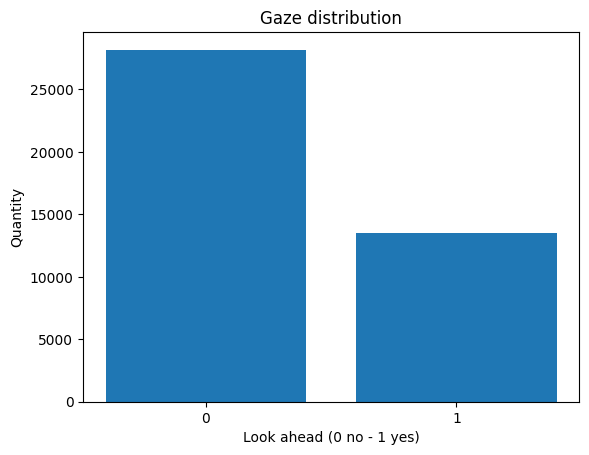

In [70]:
count_uniques_cleaned = plot_gaze_distribution(target_cleaned)

Classes distribution after data treatment: Counter({0: 28180, 1: 28180})
Number of class 0 samples (not look ahead): 28180
Number of class 1 samples (look ahead): 28180


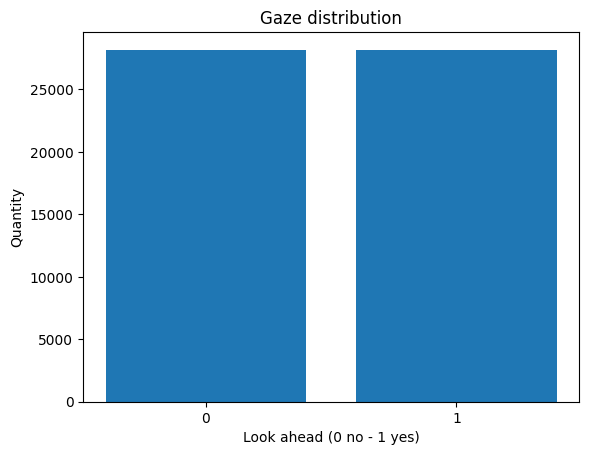

-> Train set, X shape is  (39452, 64, 64, 6) and Y shape is (39452,)
-> Test set, X shape is  (8454, 64, 64, 6) and Y shape is (8454,)
-> Validation set, X shape is  (8454, 64, 64, 6) and Y shape is (8454,)


In [71]:
# Data augmentation maintaining 6 channels with data cleaned

balanced_combined_images_cleaned, balanced_targets_cleaned = preprocessing_images_dataaug_undersampling(right_eyes_data_cleaned, left_eyes_data_cleaned, target_cleaned, count_uniques_cleaned[0])

print("Classes distribution after data treatment:", Counter(balanced_targets_cleaned))
_ = plot_gaze_distribution(balanced_targets_cleaned)

X_train_da_cleaned, y_train_da_cleaned, X_test_da_cleaned, y_test_da_cleaned, X_val_da_cleaned, y_val_da_cleaned = preprocessing_images_split_train_test_val(
    train_size=0.7, test_size=0.15, data=balanced_combined_images_cleaned, target=balanced_targets_cleaned, prints=True
)

For the final tests, and based on the detection of blurry and shaky images, the dataset has been cleaned by removing these images and data augmentation has been applied to match the classes.

## Models creation
### Simple CNN with data cleaned

In [72]:
recall_callback = RecallCallback(val_data=(X_val_da_cleaned, y_val_da_cleaned))

model_simple_cnn_cleaned = models.Sequential([   
    layers.Input(shape=(64, 64, 6)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(), #layers.Flatten()
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3, 
    decay_steps=3000, 
    decay_rate=0.95, 
    staircase=False 
)

model_simple_cnn_cleaned.compile(optimizer=Adam(learning_rate=lr_schedule), 
                loss='binary_crossentropy', 
                metrics=['accuracy'])

model_simple_cnn_cleaned.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,649 (436.13 KB)

 Trainable params: 111,201 (434.38 KB)

 Non-trainable params: 448 (1.75 KB)

In [73]:
callbacks = [
    ModelCheckpoint(
        'model_cnn_simple_50ep_32bat_cleaned_best.keras', 
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    #ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

history5 = model_simple_cnn_cleaned.fit(
    X_train_da_cleaned, y_train_da_cleaned,
    validation_data=(X_val_da_cleaned, y_val_da_cleaned),
    epochs=50,
    batch_size=32,
    callbacks=[callbacks, recall_callback]
)

Epoch 1/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7419 - loss: 0.4902
Epoch 1: val_loss improved from inf to 0.45759, saving model to model_cnn_simple_50ep_32bat_cleaned_best.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Validation Recall of class 0: 1.0000
Validation Recall of class 1: 0.5316
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 74s 58ms/step - accuracy: 0.7419 - loss: 0.4902 - val_accuracy: 0.7658 - val_loss: 0.4576
Epoch 2/50
1232/1233 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7569 - loss: 0.4637
Epoch 2: val_loss improved from 0.45759 to 0.44964, saving model to model_cnn_simple_50ep_32bat_cleaned_best.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Validation Recall of class 0: 1.0000
Validation Recall of class 1: 0.5316
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.7569 - loss: 0.4637 - val_accuracy: 0.7658 - val_loss: 0.4496
Epoch 3/50
1232/1233 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7571 - loss: 0.4580
Epoch 3: val_loss did not improve f

265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


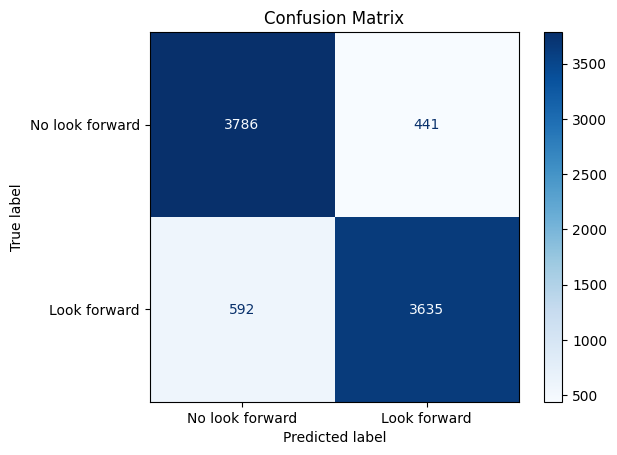

Classification Report:
                 precision    recall  f1-score   support

No look forward       0.86      0.90      0.88      4227
   Look forward       0.89      0.86      0.88      4227

       accuracy                           0.88      8454
      macro avg       0.88      0.88      0.88      8454
   weighted avg       0.88      0.88      0.88      8454

265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8792 - loss: 0.2789
Test Loss: 0.2869
Test Accuracy: 0.8778


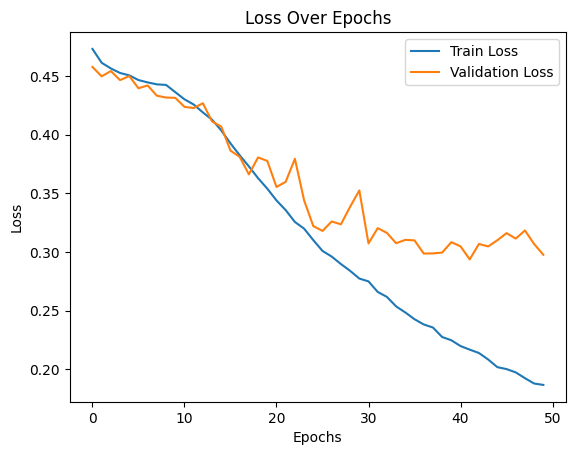

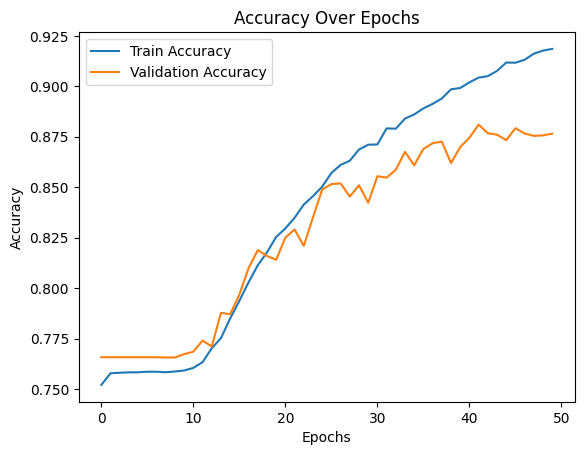

In [74]:
evaluate_process(model_simple_cnn_cleaned, X_test_da_cleaned, y_test_da_cleaned, history5)

Using the second test with the simple CNN as a basis (since it obtains slightly better results), the cleaned data created previously have been used to check if we obtain improvement in the results.

Regarding the metrics obtained from the training, the results obtained improve those obtained with the equivalent test without image cleaning. Specifically, it improves both classes (and therefore the overall accuracy) by around 2% without applying any changes beyond cleaning the dataset, showing that cleaning has an impact.

### MobileNet with 2 inputs and data cleaned

Classes distribution after data treatment: Counter({0: 28180, 1: 28180})
Number of class 0 samples (not look ahead): 28180
Number of class 1 samples (look ahead): 28180


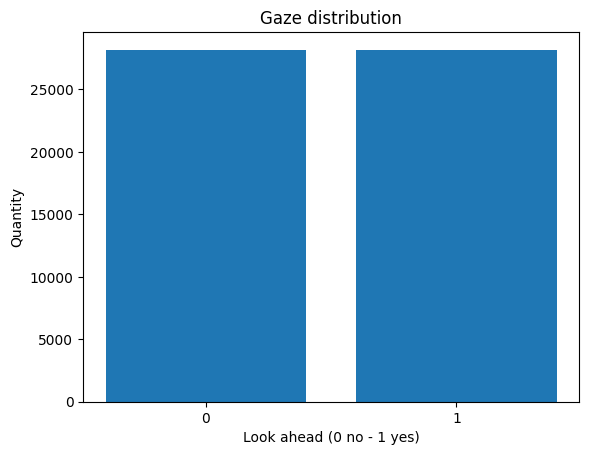

-> Train set, Right eye shape is (39452, 64, 64, 3) - left eye shape is (39452, 64, 64, 3) - target shape is (39452,)
-> Test set, Right eye shape is (8454, 64, 64, 3) - left eye shape is (8454, 64, 64, 3) - target shape is (8454,)
-> Validation set, Right eye shape is (8454, 64, 64, 3) - left eye shape is (8454, 64, 64, 3) - target shape is (8454,)


In [75]:
# Data augmentation maintaining two eyes separate, but with data cleaned

balanced_combined_right_eye_images_cleaned, balanced_combined_left_eye_images_cleaned, balanced_targets_cleaned = preprocessing_images_dataaug_undersampling(
    right_eyes_data_cleaned, left_eyes_data_cleaned, target_cleaned, count_uniques_cleaned[0], separate_eyes=True
)

print("Classes distribution after data treatment:", Counter(balanced_targets_cleaned))
_ = plot_gaze_distribution(balanced_targets_cleaned)

X_train_right_cleaned, X_train_left_cleaned, y_train_cleaned, X_test_right_cleaned, X_test_left_cleaned, y_test_cleaned, X_val_right_cleaned, X_val_left_cleaned, y_val_cleaned = preprocessing_images_split_train_test_val_separate_eyes(
    train_size=0.7, 
    test_size=0.15, 
    data_right=balanced_combined_right_eye_images_cleaned, 
    data_left=balanced_combined_left_eye_images_cleaned, 
    target=balanced_targets_cleaned, 
    prints=True
)

In [76]:
right_eye_input = Input(shape=(64, 64, 3), name="right_eye")
left_eye_input = Input(shape=(64, 64, 3), name="left_eye")

base_model_mobilenet_separatedeyes = MobileNetV2(include_top=False, input_shape=(64, 64, 3), weights='imagenet')

x_right = base_model_mobilenet_separatedeyes(right_eye_input)
x_left = base_model_mobilenet_separatedeyes(left_eye_input)

x_right = GlobalAveragePooling2D()(x_right)
x_left = GlobalAveragePooling2D()(x_left)

x_combined = layers.concatenate([x_right, x_left])

x = Dense(128, activation='relu')(x_combined)
x = layers.Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_mobilenet_separatedeyes_cleaned = Model(inputs=[right_eye_input, left_eye_input], outputs=output)
model_mobilenet_separatedeyes_cleaned.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model_mobilenet_separatedeyes_cleaned.summary()

C:\Users\josep\AppData\Local\Temp\ipykernel_22336\1147982206.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet_separatedeyes = MobileNetV2(include_top=False, input_shape=(64, 64, 3), weights='imagenet')


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ right_eye           │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ left_eye            │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 2, 2,      │  2,257,984 │ right_eye[0][0],  │
│ (Functional)        │ 1280)             │            │ left_eye[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │    327,808 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │        129 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,585,921 (9.86 MB)

 Trainable params: 2,551,809 (9.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [77]:
callbacks = [
    ModelCheckpoint(
        'model_mobilenet_separatedeyes_cleaned_50ep_32bat_best.keras', 
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

recall_callback = RecallCallback(val_data=([X_val_right_cleaned, X_val_left_cleaned], y_val_cleaned))

history6 = model_mobilenet_separatedeyes_cleaned.fit(
    [X_train_right_cleaned, X_train_left_cleaned],  
    y_train_cleaned,  
    validation_data=([X_val_right_cleaned, X_val_left_cleaned], y_val_cleaned), 
    epochs=50, 
    batch_size=32,
    callbacks=[callbacks, recall_callback]  
)

Epoch 1/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7189 - loss: 0.5387
Epoch 1: val_loss improved from inf to 0.47208, saving model to model_mobilenet_separatedeyes_cleaned_50ep_32bat_best.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step
Validation Recall of class 0: 0.8909
Validation Recall of class 1: 0.6373
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 355s 265ms/step - accuracy: 0.7190 - loss: 0.5386 - val_accuracy: 0.7641 - val_loss: 0.4721 - learning_rate: 1.0000e-04
Epoch 2/50
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.7776 - loss: 0.4186
Epoch 2: val_loss improved from 0.47208 to 0.38522, saving model to model_mobilenet_separatedeyes_cleaned_50ep_32bat_best.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step
Validation Recall of class 0: 0.9030
Validation Recall of class 1: 0.7036
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 320s 259ms/step - accuracy: 0.7776 - loss: 0.4186 - val_accuracy: 0.8033 - val_loss: 0.3852 - learning_rate: 1.0000e-04
Epoch 3/50
1233/1233 ━━━━━━━━━━━

265/265 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step


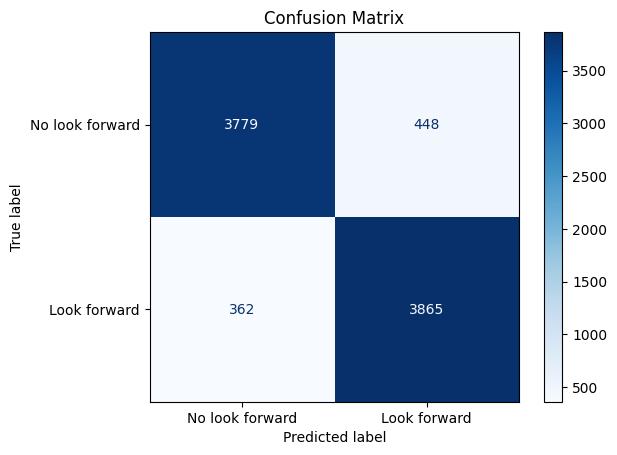

Classification Report:
                 precision    recall  f1-score   support

No look forward       0.91      0.89      0.90      4227
   Look forward       0.90      0.91      0.91      4227

       accuracy                           0.90      8454
      macro avg       0.90      0.90      0.90      8454
   weighted avg       0.90      0.90      0.90      8454

265/265 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9052 - loss: 0.2416
Test Loss: 0.2390
Test Accuracy: 0.9042


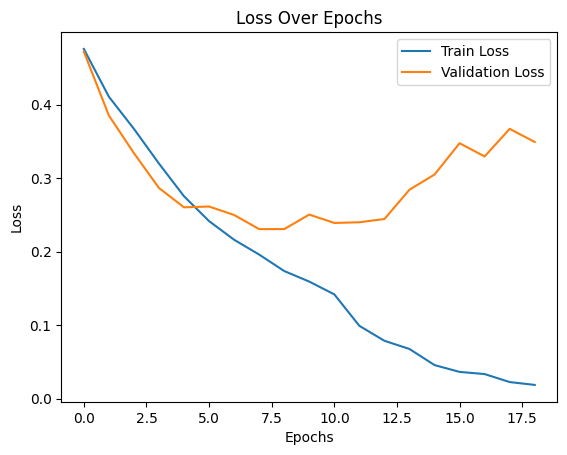

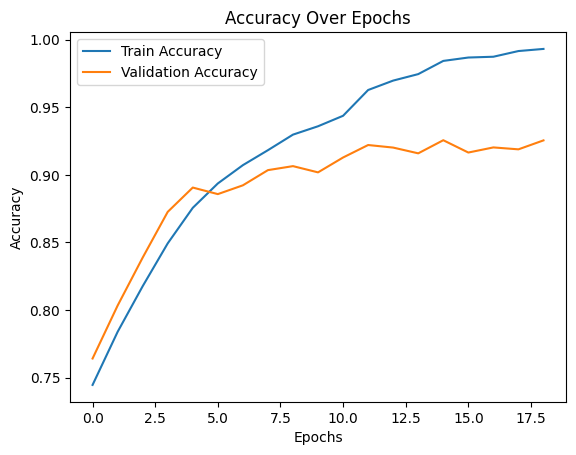

In [78]:
evaluate_process(model_mobilenet_separatedeyes_cleaned, [X_test_right_cleaned, X_test_left_cleaned], y_test_cleaned, history6)

For this last test, the training that has given the best results has been used as a starting point, which has been MovileNet with the network inputs separated for each eye. Along with this, we use the previously cleaned data, seeking to obtain the best result by combining everything learned previously.

Regarding the metrics obtained from the training, the results obtained do not improve those obtained with the equivalent test without image cleaning. Specifically, it improves both classes (and therefore the overall accuracy) is lost by around 1%, indicating that for this model the way of cleaning can have a negative impact.

Therefore, in conclusion, we can see how the way of processing the data, the layers and the ways of entering the data into the different models or hyperparameters such as the learning rate affect the different trainings. There are still an infinite number of tests that can be carried out, but a starting point is reflected when dealing with this dataset.